In [1]:
# Setting up Notebook
% matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from nose.tools import assert_equal, assert_true, assert_almost_equal, assert_is_instance, assert_is_not
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_diabetes
from sklearn.model_selection import cross_val_score

# We do this to ignore several specific warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
## HELPER CODE TO GENERATE LEARNING CURVES
def get_range(trn_szs, trn_scr, tst_scr):
    '''
    Returns the ranges of the training and testing data needed for plotting a learn curve
    
    Parameters
    ----------
    trn_szs: A numpy ndarray
    trn_scr: A numpy ndarray
    tst_scr: A numpy ndarray
    
    Returns
    -------
    A 6-tuple of numpy.ndarrays of trn_scr_mu, trn_high, trn_low, trn_scr_mu, tst_high, tst_low
    '''
        
    trn_scr_mu = np.mean(trn_scr, axis=1)
    trn_scr_sig = np.std(trn_scr, axis=1)

    trn_high = np.array(trn_scr_mu) + np.array(trn_scr_sig)
    trn_low = np.array(trn_scr_mu) - np.array(trn_scr_sig)

    tst_scr_mu = np.mean(tst_scr, axis=1)
    tst_scr_sig = np.std(tst_scr, axis=1)

    tst_high = np.array(tst_scr_mu) + np.array(tst_scr_sig)
    tst_low = np.array(tst_scr_mu) - np.array(tst_scr_sig)
        
    return(trn_scr_mu, trn_high, trn_low, tst_scr_mu, tst_high, tst_low)


def lv_plot(ttle, x, y1, y1h, y1l, y2, y2h, y2l, xlbl, ylbl, ylim=None):
    '''
    Returns a matplotlib.Axes instance that plots the learning curve
    
    Parameters
    ----------
    ttle: string
    x: A numpy ndarray
    y1: A numpy ndarray
    y1h: A numpy ndarray
    y1l: A numpy ndarray
    y2: A numpy ndarray
    y2h: A numpy ndarray
    y2l: A numpy ndarray
    xlbl: string
    ylbl: string
    ylim: tuple of floats
    
    
    Returns
    -------
    ax: A matplotlib.Axes instance.
    '''
        
    # Plot the results
    fig, ax = plt.subplots(figsize=(10,8))

    trn_color = color=sns.xkcd_rgb["denim blue"]
    ax.plot(x, y1, label="Training Score", marker='d', lw=3, color=trn_color)
    ax.fill_between(x, y1h, y1l, alpha=0.25, color=trn_color)

    tst_color = color=sns.xkcd_rgb["medium green"]
    ax.plot(x, y2, label="CV Score", marker='d', lw=3, color=tst_color)
    ax.fill_between(x, y2h, y2l, alpha=0.25, color=tst_color)

    # Decorate plot
    ax.set(title=ttle, xlabel=xlbl, ylabel=ylbl)

    if ylim is not None:
        ax.set_ylim(*ylim)
        
    ax.legend(loc='best', borderaxespad=1.5)
    sns.despine(offset=10, trim=True)
    
    return ax

### Importing dataset - Diabetes

In [3]:
columns = "age sex bmi map tc ldl hdl tch ltg glu".split()
# Load in the dataset as a Pandas DataFrame
data = load_diabetes()
data_df = pd.DataFrame(data.data, columns=columns)
# Preview the first few lines
data_df.head()

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


In [4]:
'''
Separate the dataset into training and testing data using the `train_test_split` function.
'''
size = 0.3

data_df_clean = data_df[data_df.columns[:-1]]
labels = data.target
# YOUR CODE HERE

d_train, d_test, l_train, l_test=\
train_test_split(data_df_clean, labels, test_size = size, random_state = 23)

## Create Model and Score using K-fold

In [5]:
def score_kfold(cv, data, labels):
    '''
    Creates a LinearRegression model and scores it using
    K-fold cross-validation
    
    Parameters
    ----------
    cv: An integer.
    data: A numpy ndarray
    labels: A numpy ndarray
    
    Returns
    -------
    A 2-tuple of the LinearRegression object and the cross-validation scores.
    '''
        
    # Create Linear Regression Model
    RGR = LinearRegression()
    scores = cross_val_score(RGR, data, labels, cv= cv)
        
    return (RGR, scores)    

In [6]:
# Create a model with k-fold=3

model = score_kfold(3, data.data, labels)[0]

## Score using StratifiedKFold

In [7]:
def score_stratified_kfold(n_splits, data, labels):
    '''
    Score our previous model using the StratifiedKFold strategy
    
    Parameters
    ----------
    n_splits: An integer
    data: A numpy ndarray
    labels: A numpy ndarray
    
    Returns
    -------
    2-tuple of the StratifiedKFold object and the numpy array of the scores
    '''
    
    RGR = LinearRegression()
    
    skf = StratifiedKFold(n_splits= n_splits, random_state=23)
    
    scores = cross_val_score(RGR, data, labels, cv= skf)
    
    return (skf, scores)    

### Generate Learning Curve

In [8]:
def generate_learning_curve(data, labels):
    '''
    Generate a Learning Curve for the LinearRegression model from above.
    
    Parameters
    ----------
    data: A numpy ndarray
    labels: A numpy ndarray
    
    Returns
    -------
    ax: A matplotlib.Axes instance.
    '''
        
    skf = StratifiedKFold(n_splits= 5, random_state=23)
    
    RGR = LinearRegression()
    
    trn_sz=np.linspace(0.1, 1, 30)
        
    # Generate learning curve
    trn_szs, trn_scr, tst_scr = \
        learning_curve(RGR, data, labels, cv= skf, train_sizes= trn_sz)
    
    # Returns the ranges of the training and testing data needed for plotting a learn curve
    trn_scr_mu, trn_high, trn_low, tst_scr_mu,\
        tst_high, tst_low = get_range(trn_szs, trn_scr, tst_scr)
    
    # Returns a matplotlib.Axes instance that plots the learning curve
    ttle = 'Learning Curve with Linear Regression'
    x = trn_szs
    y1 = trn_scr_mu
    y1h = trn_high
    y1l = trn_low
    y2 = tst_scr_mu
    y2h = tst_high
    y2l = tst_low
    xlbl = 'Training Size'
    ylbl = 'Score'
    
    ax = lv_plot(ttle, x, y1, y1h, y1l, y2, y2h, y2l, xlbl, ylbl, ylim= (0.0, 0.7))
    
    return ax    

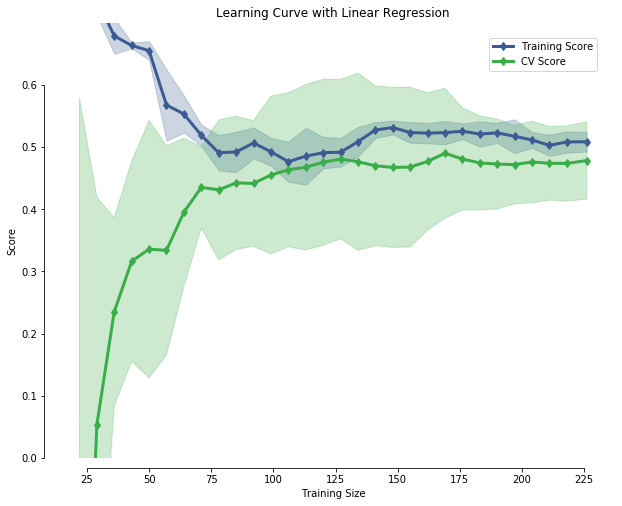

In [9]:
ax = generate_learning_curve(data.data, labels)